In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.9 MB/s eta 0:00:00


In [ ]:
#Importing Dependencies
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
from jiwer import wer
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
dataUrl = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
dataPath = keras.utils.get_file("LJSpeech-1.1", dataUrl,untar=True)



2748572632/2748572632 [==============================] - 140s 0us/step


In [ ]:
wavsPath =dataPath+"/wavs/"
metadataPath =dataPath+"/metadata.csv"

In [ ]:
metadata = pd.read_csv(metadataPath, sep="|", header=None, quoting=3)
metadata.head()

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [ ]:
metadata.shape

(13100, 3)

In [ ]:
metadata.columns = ["File Name", "Transcription", "Normalized Transcription"]
metadata = metadata[["File Name", "Normalized Transcription"]]
metadata = metadata.sample(frac=1).reset_index(drop=True)
metadata.head(5)

,File Name,Normalized Transcription
0,LJ004-0193,Prisoners on reception were treated as they ar...
1,LJ018-0205,Cummings was caught shortly afterwards.
2,LJ041-0025,It has been suggested that this misspelling of...
3,LJ015-0062,but in neither did the sums misappropriated re...
4,LJ019-0378,"As the almost inevitable consequence, while th..."


# Splitting Data into Training and Validation dataset

In [ ]:
splitRatio = int(len(metadata) * 0.90)
trainData = metadata[:splitRatio]
valData = metadata[splitRatio:]
print(f"Size of the training set: {len(trainData)}")
print(f"Size of the training set: {len(valData)}")

Size of the training set: 11790
Size of the training set: 1310


# Preprocessing

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(f"Vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

Vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [ ]:
#The window length in samples.
frame_length = 256
#The number of samples to step.
frame_step = 160
# The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


In [ ]:
def encode_single_sample(wav_file, label):
    #Process the Audio
    # 1. Read wav file
    file = tf.io.read_file(wavsPath + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file) #convert the wave file to float tensor
    audio = tf.squeeze(audio, axis=-1) #  Squeeze the tensor along the last axis
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

# Creating dataset objects

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(trainData["File Name"]), list(trainData["Normalized Transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(valData["File Name"]), list(valData["Normalized Transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Visualizing data

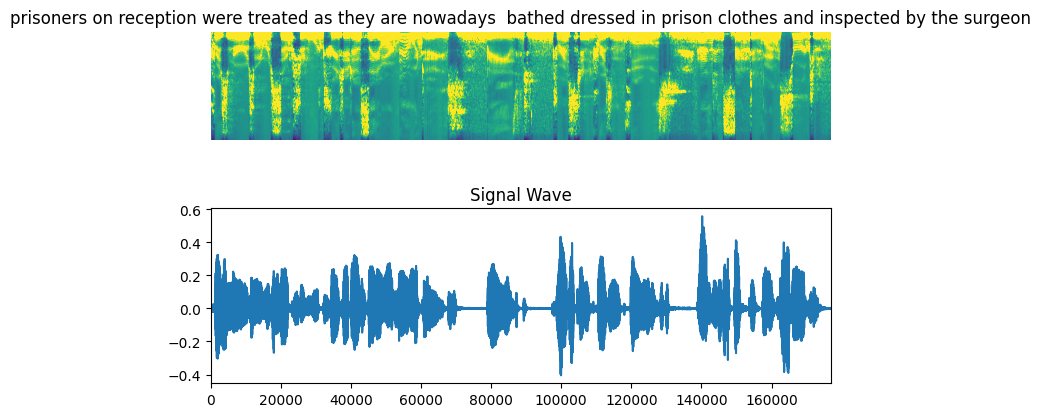

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavsPath + list(trainData["File Name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

# Model

In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), input_shape=(None, input_dim), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
checkpoint_path = "speech_recognition_model_weights_epoch_{epoch:02d}.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch'
)

In [ ]:
# Define the number of epochs.
epochs = 50
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback,checkpoint_callback],
)

Epoch 1/50
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : was another act which expressed his hostility toward the united states and its institutions as well as a concomitant attachment
Prediction: ssssnnsss
----------------------------------------------------------------------------------------------------
Target    : the chronicles of newgate volume two by arthur griffiths section seventeen newgate notorieties continued part two
Prediction: ssnsn
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 2091s 6s/step - loss: 298.7749 - val_loss: 278.9056
Epoch 2/50
1/1 [==============================] - 1s 663ms/step
----------------------------------------------

# Inference

In [ ]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 1s 597ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6118
----------------------------------------------------------------------------------------------------
Target    : few if any showed any feeling of terror none were impressed with the solemnity or realized the warning which the sight conveyed
Prediction: fuif any sho any fieeling of terr non were impres with the slenety or realise the orning which the sigke conva
----------------------------------------------------------------------------------------------------
Target    : dressing the same eating the same food as did their ancestors when nebuchadnezzar built the walls of babylon
Prediction: dresing the sain eting the same od isded ther ansesters wen nevbucad neaer bi e wals of bablon
----------------------------------------------------------------------------------------------------
Target    : they were taken 

In [ ]:
model.save('speech_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('speech_recognition_model.h5', custom_objects={'CTCLoss': CTCLoss})

In [ ]:
import librosa

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(result).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

# A function to transcribe audio
def transcribe_audio(audio_path):
    # Load and preprocess the audio file for prediction
    audio, _ = librosa.load(audio_path, sr=16000)  # Adjust sample rate if needed
    audio = np.expand_dims(audio, axis=0)

    # Make predictions
    predictions = model1.predict(audio)
    transcription = decode_batch_predictions(predictions)[0]

    return transcription

# Example usage
audio_path = "/maybe-next-time.wav"
result = transcribe_audio(audio_path)
print("Transcription:", result)

ValueError: ignored

In [ ]:
for batch in validation_dataset:
    X, y = batch
    # print(X)
    batch_predictions = model1.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    print(batch_predictions)

1/1 [==============================] - 1s 760ms/step
['but antlingt manngh to reglelout of the chaing which confine his body and somloson the ros rount hisket', 'poiver the va reques for in formation which the secredt service mad', 'and ebals the should avbeen spetly ruhed out remained ecas thy had the presrition of ong usee', 'when o er not he coudpositivly identifi the man he saw in the six flor windo as the same man he so in the polistation', 'the is tarigate way leading to the balas was in cast wof the butaful blglase bric', 'sho was smartlydrest in apland shal a wit lae cha', 'were poblicly expose in a stable inlitl prig stry nere uppothe carise wal', 'into the service of the privlenge f', 'he sat on abenh befor the pulpt the hi e as condemne p had beenswectwa and never ons rase his i drings', 'both derecter hover and belmont exprest to the commision the great consern of the fbi which is shared by the secret seri', 'these facts warad the finding that le harvy oswald disposed of h 

KeyboardInterrupt: ignored

In [ ]:
app.py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import load_model
from gtts import gTTS
import os
import numpy as np
from sklearn.model_selection import train_test_split
import unicodedata
import re
import io
import time
import sqlite3
from flask import Flask, request, render_template,url_for, redirect,send_file

app = Flask(__name__,static_url_path='/static')
feedback_data = [
    # {"rating": 5, "comment": "Great product!"},
    # {"rating": 4, "comment": "Could be better."},
    # {"rating": 3, "comment": "Average"},
    # {"rating": 2, "comment": "Not up to the mark"},
    # {"rating": 1, "comment": "Poor"}
]


def calculate_average_rating(feedback):
    if not feedback:
        return 0
    total = sum(entry["rating"] for entry in feedback)
    return total / len(feedback)

def initialize_database():
    conn = sqlite3.connect('feedback.db')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS feedback (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            rating INTEGER NOT NULL,
            comment TEXT
        )
    ''')
    conn.commit()
    conn.close()

@app.route('/')
def home():
    return render_template("audio-only.html")

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == "POST":
        if 'file' not in request.files:
            return "No file part"
        audioFile = request.files['file']

        directory_path = "/home/dhanush/Documents/ML/MinorProject/static/audio"
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

        file_path = os.path.join(directory_path, audioFile.filename)
        global input_mp3_path
        input_mp3_path=file_path
        audioFile.save(file_path)
        frame_length = 256
        frame_step = 160
        fft_length = 384
        characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

        # Mapping characters to integers
        char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

        # Mapping integers back to original characters
        num_to_char = keras.layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
        )
        batch_size = 32
        def decode_batch_predictions(pred):
            input_len = np.ones(pred.shape[0]) * pred.shape[1]
        # Use greedy search. For complex tasks, you can use beam search
            results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
        # Iterate over the results and get back the text
            output_text = []
            for result in results:
                result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
                output_text.append(result)
            return output_text
        def encode_single_sample(wav_file):
        # Process the Audio
        # 1. Read wav file
            file = tf.io.read_file(wav_file)
        # 2. Decode the wav file
            audio, _ = tf.audio.decode_wav(file)
        # 3. Squeeze the tensor along the channel axis
            audio = tf.squeeze(audio, axis=-1)
        # 4. Change type to float
            # if len(audio.shape) > 1:
            # # If there's an extra dimension, select the first channel
            #     audio = audio[:, 0]
            audio = tf.cast(audio, tf.float32)
        # 5. Get the spectrogram
            spectrogram = tf.signal.stft(
                audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
            )
        # 6. We only need the magnitude, which can be derived by applying tf.abs
            spectrogram = tf.abs(spectrogram)
            spectrogram = tf.math.pow(spectrogram, 0.5)
        # 7. Normalization
            means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
            stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
            spectrogram = (spectrogram - means) / (stddevs + 1e-10)
            return spectrogram
        def CTCLoss(y_true, y_pred):
        # Compute the training-time loss value
            batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
            input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
            label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

            input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
            label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

            loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
            return loss
        def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
            """Model similar to DeepSpeech2."""
            # Model's input
            input_spectrogram = layers.Input((None, input_dim), name="input")
            # Expand the dimension to use 2D CNN.
            x = layers.Reshape((-1, input_dim, 1), input_shape=(None, input_dim), name="expand_dim")(input_spectrogram)
            # Convolution layer 1
            x = layers.Conv2D(
                filters=32,
                kernel_size=[11, 41],
                strides=[2, 2],
                padding="same",
                use_bias=False,
                name="conv_1",
            )(x)
            x = layers.BatchNormalization(name="conv_1_bn")(x)
            x = layers.ReLU(name="conv_1_relu")(x)
            # Convolution layer 2
            x = layers.Conv2D(
                filters=32,
                kernel_size=[11, 21],
                strides=[1, 2],
                padding="same",
                use_bias=False,
                name="conv_2",
            )(x)
            x = layers.BatchNormalization(name="conv_2_bn")(x)
            x = layers.ReLU(name="conv_2_relu")(x)
            # Reshape the resulted volume to feed the RNNs layers
            x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
            # RNN layers
            for i in range(1, rnn_layers + 1):
                recurrent = layers.GRU(
                    units=rnn_units,
                    activation="tanh",
                    recurrent_activation="sigmoid",
                    use_bias=True,
                    return_sequences=True,
                    reset_after=True,
                    name=f"gru_{i}",
                )
                x = layers.Bidirectional(
                    recurrent, name=f"bidirectional_{i}", merge_mode="concat"
                )(x)
                if i < rnn_layers:
                    x = layers.Dropout(rate=0.5)(x)
            # Dense layer
            x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
            x = layers.ReLU(name="dense_1_relu")(x)
            x = layers.Dropout(rate=0.5)(x)
            # Classification layer
            output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
            # Model
            model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
            # Optimizer
            opt = keras.optimizers.Adam(learning_rate=1e-4)
            # Compile the model and return
            model.compile(optimizer=opt, loss=CTCLoss)
            return model

        model1 = load_model('speech_recognition_model.h5', custom_objects={'CTCLoss': CTCLoss})

        wav_file=audioFile

        def decode_batch_predictions(pred, beam_width=5):
            input_len = np.ones(pred.shape[0]) * pred.shape[1]
            # Use beam search instead of greedy search
            results = keras.backend.ctc_decode(pred, input_length=input_len, beam_width=beam_width, top_paths=1)[0][0]
            # Iterate over the results and get back the text
            output_text = []
            for result in results:
                result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
                output_text.append(result)
            return output_text
        X =encode_single_sample(file_path)
        X = tf.expand_dims(X, axis=0)
        batch_predictions = model1.predict(X)
        batch_predictions = decode_batch_predictions(batch_predictions)
        # print(batch_predictions)
        path_to_file ='spa.txt'
        def unicode_to_ascii(s):
            return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
        def preprocess_sentence(w):
            w = unicode_to_ascii(w.lower().strip())
        #w = w.lower().strip()

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
            w = re.sub(r"([?.!,¿])", r" \1 ", w)
            w = re.sub(r'[" "]+', " ", w)

            # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
            #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

            w = w.lstrip().strip()

            # adding a start and an end token to the sentence
            # so that the model know when to start and stop predicting.
            w = '<start> ' + w + ' <end>'
            return w
        def create_dataset(path, num_examples):
        #lines = io.open('hin.txt', encoding='UTF-8').read().split('\n')
        #lines = lines.strip().split('\n')
        #lines = io.open(path, encoding='UTF-8').readlines().strip().split('\n')
            lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
            word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

            return zip(*word_pairs)
        def max_length(tensor):
            return max(len(t) for t in tensor)
        def tokenize(lang):
            lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
            lang_tokenizer.fit_on_texts(lang)

            tensor = lang_tokenizer.texts_to_sequences(lang)

            tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

            return tensor, lang_tokenizer
        def load_dataset(path, num_examples=None):
        # creating cleaned input, output pairs
            inp_lang, targ_lang, _ = create_dataset(path, num_examples)

            input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
            target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

            return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer
        num_examples = 3000
        input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

        # Calculate max_length of the target tensors
        max_length_inp, max_length_targ = max_length(input_tensor), max_length(target_tensor)

        input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,
                                                                                                    target_tensor,
                                                                                                    test_size=0.2)
        def convert(lang, tensor):
            for t in tensor:
                if t!=0:
                    print ("%d ----> %s" % (t, lang.index_word[t]))
        BUFFER_SIZE = len(input_tensor_train)
        BATCH_SIZE = 32
        steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
        embedding_dim = 256
        units = 1024
        vocab_inp_size = len(inp_lang.word_index)+1
        vocab_tar_size = len(targ_lang.word_index)+1

        dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        example_input_batch, example_target_batch = next(iter(dataset))
        class Encoder(tf.keras.Model):
            def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
                super(Encoder, self).__init__()
                self.batch_sz = batch_sz
                self.enc_units = enc_units
                self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
                self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True,
                                                return_state=True, recurrent_initializer='glorot_uniform')

            def call(self, x, hidden):
                x = self.embedding(x)
                output, state = self.gru(x, initial_state = hidden)
                return output, state

            def initialize_hidden_state(self):
                return tf.zeros((self.batch_sz, self.enc_units))
        encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
        class BahdanauAttention(tf.keras.Model):
            def __init__(self, units):
                super(BahdanauAttention, self).__init__()
                self.W1 = tf.keras.layers.Dense(units)
                self.W2 = tf.keras.layers.Dense(units)
                self.V = tf.keras.layers.Dense(1)

            def call(self, query, values):
                # hidden shape == (batch_size, hidden size)
                # hidden_with_time_axis shape == (batch_size, 1, hidden size)
                # we are doing this to perform addition to calculate the score
                hidden_with_time_axis = tf.expand_dims(query, 1)

                # score shape == (batch_size, max_length, 1)
                # we get 1 at the last axis because we are applying score to self.V
                # the shape of the tensor before applying self.V is (batch_size, max_length, units)
                score = self.V(tf.nn.tanh(
                    self.W1(values) + self.W2(hidden_with_time_axis)))

                # attention_weights shape == (batch_size, max_length, 1)
                attention_weights = tf.nn.softmax(score, axis=1)

                # context_vector shape after sum == (batch_size, hidden_size)
                context_vector = attention_weights * values
                context_vector = tf.reduce_sum(context_vector, axis=1)
                return context_vector, attention_weights
        class Decoder(tf.keras.Model):
            def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
                super(Decoder, self).__init__()
                self.batch_sz = batch_sz
                self.dec_units = dec_units
                self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
                self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True,
                                                return_state=True, recurrent_initializer='glorot_uniform')
                self.fc = tf.keras.layers.Dense(vocab_size)

                # used for attention
                self.attention = BahdanauAttention(self.dec_units)

            def call(self, x, hidden, enc_output):
                # enc_output shape == (batch_size, max_length, hidden_size)
                context_vector, attention_weights = self.attention(hidden, enc_output)

                # x shape after passing through embedding == (batch_size, 1, embedding_dim)
                x = self.embedding(x)

                # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
                x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

                # passing the concatenated vector to the GRU
                output, state = self.gru(x)

                # output shape == (batch_size * 1, hidden_size)
                output = tf.reshape(output, (-1, output.shape[2]))

                # output shape == (batch_size, vocab)
                x = self.fc(output)
                return x, state, attention_weights

        decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

        optimizer = tf.keras.optimizers.Adam()
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        def loss_function(real, pred):
            mask = tf.math.logical_not(tf.math.equal(real, 0))
            loss_ = loss_object(real, pred)

            mask = tf.cast(mask, dtype=loss_.dtype)
            loss_ *= mask

            return tf.reduce_mean(loss_)
        checkpoint_dir = './training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
        @tf.function
        def train_step(inp, targ, enc_hidden):
            loss  = 0

            with tf.GradientTape() as tape:
                enc_output, enc_hidden = encoder(inp, enc_hidden)

                dec_hidden = enc_hidden

                dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

                # Teacher forcing - feeding the target as the next input
                for t in range(1, targ.shape[1]):
                    # passing enc_output to the decoder
                    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

                    loss += loss_function(targ[:, t], predictions)

                    # using teacher forcing
                    dec_input = tf.expand_dims(targ[:, t], 1)

            batch_loss = (loss / int(targ.shape[1]))

            variables = encoder.trainable_variables + decoder.trainable_variables

            gradients = tape.gradient(loss, variables)

            optimizer.apply_gradients(zip(gradients, variables))

            return batch_loss
        def evaluate(sentence):
            attention_plot = np.zeros((max_length_targ, max_length_inp))

            sentence = preprocess_sentence(sentence)

            inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
            inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
            inputs = tf.convert_to_tensor(inputs)

            result = ''

            hidden = [tf.zeros((1, units))]
            enc_out, enc_hidden = encoder(inputs, hidden)

            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

            for t in range(max_length_targ):
                predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

                # storing the attention weights to plot later on
                attention_weights = tf.reshape(attention_weights, (-1, ))
                attention_plot[t] = attention_weights.numpy()

                predicted_id = tf.argmax(predictions[0]).numpy()

                result += targ_lang.index_word[predicted_id] + ' '

                if targ_lang.index_word[predicted_id] == '<end>':
                    return result, sentence, attention_plot

                # the predicted ID is fed back into the model
                dec_input = tf.expand_dims([predicted_id], 0)

            return result, sentence, attention_plot
        def translate(sentence):
            result, sentence, attention_plot = evaluate(sentence)
            return result
        checkpoint_dir='training_checkpoints'

        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        def filter_words_not_in_dict(sentence, inp_lang):
            words = sentence.split()
            lower_case_word_index = {word.lower() for word in inp_lang.word_index}
            filtered_words = [word for word in words if word.lower() in lower_case_word_index]
            filtered_sentence = ' '.join(filtered_words)
            return filtered_sentence
        filtered_sentence = filter_words_not_in_dict(batch_predictions[0], inp_lang)
        output=translate(filtered_sentence)


        def text_to_sound(text, language='es', filename='/home/dhanush/Documents/ML/MinorProject/static/audio/output.mp3'):
            # Create a gTTS object
            tts = gTTS(text=text, lang=language, slow=False)

            # Save the speech as an MP3 file
            tts.save(filename)
        text_to_sound(output)
    arr = 'ENGLISH SENTENCE IS: '+ batch_predictions[0]
    zrr= "TRANSALATION IS: " + output
    return render_template("audio-only.html", pred1=arr,pred2=zrr)
    # return send_file('/home/dhanush/Documents/ML/MinorProject/output.mp3', as_attachment=False)
@app.route('/about')
def about():
    return render_template('about.html')

output_mp3_path = '/home/dhanush/Documents/ML/MinorProject/static/audio/output.mp3'

@app.route('/get_output_audio')
def get_output_audio():
    # Check if the output.mp3 file exists
    if os.path.exists(output_mp3_path):
        # Send the output.mp3 file as a response
        return send_file(output_mp3_path, as_attachment=False)
    else:
        return "File not found"

@app.route('/get_input_audio')
def get_input_audio():
    # Check if the output.mp3 file exists
    if os.path.exists(input_mp3_path):
        # Send the output.mp3 file as a response
        return send_file(input_mp3_path, as_attachment=False)
    else:
        return "File not found"

# @app.route('/feedback', methods=['GET', 'POST'])
# def feedback():
#     if request.method == 'POST':
#         name= request.form['name']
#         rating = int(request.form['rating'])
#         comment = request.form['comment']

#         # Append new feedback to the list
#         feedback_data.append({"name":name,"rating": rating, "comment": comment})

#     avg_rating = calculate_average_rating(feedback_data)
#     return render_template('feedback.html', feedback_data=feedback_data, avg_rating=avg_rating)

@app.route('/feedback', methods=['GET', 'POST'])
def feedback():
    conn = sqlite3.connect('feedback.db')
    c = conn.cursor()

    if request.method == 'POST':
        name = request.form['name']
        rating = int(request.form['rating'])
        comment = request.form['comment']

        c.execute('''
            INSERT INTO feedback (name, rating, comment) VALUES (?, ?, ?)
        ''', (name, rating, comment))
        conn.commit()

    c.execute('SELECT name, rating, comment FROM feedback')
    columns = [col[0] for col in c.description]  # Fetch column names
    feedback_data = [dict(zip(columns, row)) for row in c.fetchall()]  # Convert rows to dictionaries

    avg_rating = calculate_average_rating(feedback_data)

    conn.close()
    return render_template('feedback.html', feedback_data=feedback_data, avg_rating=avg_rating)

if __name__ == "__main__":
    initialize_database()
    app.run(debug=True)

In [ ]:
audio-only.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <title>Audio-only Example - Record Plugin for Video.js</title>

    <!-- Existing CSS links -->
    <link href="../node_modules/video.js/dist/video-js.min.css" rel="stylesheet">
    <link href="../node_modules/videojs-wavesurfer/dist/css/videojs.wavesurfer.min.css" rel="stylesheet">
    <link href="../dist/css/videojs.record.css" rel="stylesheet">
    <link href="assets/css/examples.css" rel="stylesheet">

    <!-- <link rel="stylesheet" href="{{ url_for('static', filename='css/video-js.min.css') }}">
    <link rel="stylesheet" href="{{ url_for('static', filename='css/videojs.wavesurfer.min.css') }}">

    <link rel="stylesheet" href="{{ url_for('static', filename='css/videojs.record.css') }}">
    <link rel="stylesheet" href="{{ url_for('static', filename='css/examples.css') }}"> -->




    <!-- Additional CSS for the players and heading -->
    <style>
        body {
            margin: 0;
            padding: 0;
            background-image: url("static/Images/pexels-pixabay-355747.jpg");
            background-size: cover;
            background-position: center;
            font-family: Arial, Helvetica, sans-serif;
            height: 100vh;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
        }

        #heading {
            color: black;
            font-size: 4em; /* Increased size by 2 times */
            margin-top: 17px;
            margin-bottom: 428px;
        }

        #myAudio,
        #voicePlayer,
        #audioPlayer {
            margin-top: 25px;
            margin-bottom: 65px;
            width: 50%;
            z-index: 2;
            background-color: rgba(255, 131, 0, 0);
        }
         /* Add the following styles to darken the play button and player bar */
         .vjs-button-control.vjs-play-control:before {
            color: #333; /* Darkened color (replace with your preferred color) */
        }

        #myAudio .vjs-play-progress,
        #myAudio .vjs-volume-level {
            background-color: #050; /* Darkened color (replace with your preferred color) */
        }

        #myAudio .vjs-control-bar {
            background-color: #333; /* Darkened color (replace with your preferred color) */
        }

        #button-container {
            display: flex;
        }

        #chooseFileLabel {
            background-color: black;
            color: white;
            font-size: 1.3em;
            padding: 7px 8px;
            border: none;
            cursor: pointer;
            border-radius: 35px;
            margin-left: 10px; /* Adjusted to shift the button to the left */
            margin-bottom:70px;

        }

        #fileDisplay {
            color: black;
            font-size: 1.5em;
            font-weight: bold; /* Added to make text bolder */
            padding: 10px;
            margin-left: 10px;
        }

        #upload {
            background-color: black;
            color: white;
            font-size: 1.3em;
            padding: 7px 8px;
            border: none;
            cursor: pointer;
            border-radius: 35px;
        }

        input[type="file"] {
            display: none;
        }
    </style>

    <!-- Existing JavaScript links  -->
    <script src="../node_modules/video.js/dist/video.min.js"></script>
    <script src="../node_modules/recordrtc/RecordRTC.js"></script>
    <script src="../node_modules/webrtc-adapter/out/adapter.js"></script>
    <script src="../node_modules/wavesurfer.js/dist/wavesurfer.min.js"></script>
    <script src="../node_modules/wavesurfer.js/dist/plugin/wavesurfer.microphone.min.js"></script>
    <script src="../node_modules/videojs-wavesurfer/dist/videojs.wavesurfer.min.js"></script>

    <script src="../dist/videojs.record.js"></script>

    <script src="browser-workarounds.js"></script>
    <!-- <script src="{{ url_for('static', filename='video.js/dist/video.min.js') }}"></script>
    <script src="{{ url_for('static', filename='recordrtc/RecordRTC.js') }}"></script>
    <script src="{{ url_for('static', filename='webrtc-adapter/out/adapter.js') }}"></script>
    <script src="{{ url_for('static', filename='wavesurfer.js/dist/wavesurfer.min.js') }}"></script>

    <script src="{{ url_for('static', filename='wavesurfer.js/dist/plugin/wavesurfer.microphone.min.js') }}"></script>
    <script src="{{ url_for('static', filename='videojs-wavesurfer/dist/videojs.wavesurfer.min.js') }}"></script>
    <script src="{{ url_for('static', filename='videojs.record.js') }}"></script>


    <script src="{{ url_for('static', filename='browser-workarounds.js') }}"></script> -->


    <!-- Existing Style -->
    <style>
        /* Change player background color */
        #myAudio {
            background-color: (0, 0, 0, 0.5);
        }
    </style>
    <style>
        /* Style for the button */
        .about-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 117px; /* Adjust right position */
        }
        .about-button button {
            margin-right: 10px; /* Increase the margin between buttons */
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
        .home-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 177px;  /* Adjust left position */
    /* Additional styles if needed */
        }
        .home-button button {
    /* Add specific styles if needed */
            margin-right: 20px; /* Increase the margin between buttons */
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
        .feedback-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 22px; /* Adjust right position */
        }
        .feedback-button button {
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
    </style>
    <style>
        .audio-container {
            display: flex;
            justify-content: space-between;
            /* position: fixed; */
            bottom: 10;
            left: 10;
            width: 50%;
            background-color:rgba(0, 0, 0, 0);
;
            padding: 10px;
        }
        .audio {
            width: 45%;
        }
    </style>
    <style>
        .color-box {
            position: absolute;
            width: 38%; /* Adjust the width of the box */
            height:40%; /* Adjust the height of the box */
            top: 30%; /* Align with the top position */
            border-radius: 10px; /* Add rounded corners */
            }

            /* Style for the first color box */
            #color-box1 {
            left: 5.2%;
            top: 25%; /* Align with the left position of the first h4 element */
            background-color: rgba(0, 0, 0,0.5); /* Color for the first box */
            }

            /* Style for the second color box */
            #color-box2 {
            left: 58.5%;
            top: 25%;/* Align with the left position of the second h4 element */
            background-color: rgba(0,0,0,0.5); /* Color for the second box */
            }
    </style>
    <!-- ... Other styles ... -->

</head>
<body>

<!-- Aesthetic Heading -->
<h1 id="heading" style="color: black;">Voice Translation System</h1>
<a href="/about" class="about-button"><button>About</button></a>
<a href="/feedback" class="feedback-button"><button>Feedback</button></a>
<a href="/" class="home-button"><button>Home</button></a>

<!-- <audio id="myAudio" class="video-js vjs-default-skin"></audio> -->
<!-- <audio id="audioPlayer" controls class="video-js vjs-default-skin"></audio> -->

<!-- <audio id="voicePlayer" class="video-js vjs-default-skin"></audio> -->
<div id="button-container">
    <form method="POST" action="{{url_for('predict')}}" enctype="multipart/form-data">
        <label for="fileInput" id="chooseFileLabel">Choose file</label>
        <!-- <div class="file-display" id="fileDisplay"></div> -->
        <input id="fileInput" name="file" type="file" >
        <button id="upload" type="submit" value = "predict">Upload</button>
        <div class="box-container">
            <div class="color-box" id="color-box1"></div>
            <div class="color-box" id="color-box2"></div>
            <h5 style="color: rgb(240, 240, 240); position:absolute; top: 20%; left: 6%;right:57%; font-size: 0.8cm">{{ pred1 }}</h5>
            <h5 style="color: rgb(240, 240, 240); position:absolute; top: 20%; left: 60%; right:5%; font-size: 0.8cm">{{ pred2 }}</h5>
          </div>
    </form>
</div>
<!-- <audio id="audioPlayer" controls class="video-js vjs-default-skin"></audio> -->
<!-- <audio controls>
    <source src="{{ url_for('get_input_audio') }}" type="audio/mp3">
    Your browser does not support the audio element.
</audio>
<audio controls>
    <source src="{{ url_for('get_output_audio') }}" type="audio/mp3">
    Your browser does not support the audio element.
</audio> -->

<div class="audio-container">
    <div class="audio">
        <audio controls>
            <source src="{{ url_for('get_input_audio') }}" type="audio/mp3">
            Your browser does not support the audio element.
        </audio>
    </div>
    <div class="audio">
        <audio controls>
            <source src="{{ url_for('get_output_audio') }}" type="audio/mp3">
            Your browser does not support the audio element.
        </audio>
    </div>
</div>



<script>
    /* eslint-disable */
    var options = {
        controls: true,
        bigPlayButton: false,
        width: 600,
        height: 300,
        fluid: false,
        plugins: {
            wavesurfer: {
                backend: 'WebAudio',
                waveColor: '#36393b',
                progressColor: 'black',
                displayMilliseconds: true,
                debug: true,
                cursorWidth: 1,
                hideScrollbar: true,
                plugins: [
                    // enable microphone plugin
                    WaveSurfer.microphone.create({
                        bufferSize: 4096,
                        numberOfInputChannels: 1,
                        numberOfOutputChannels: 1,
                        constraints: {
                            video: false,
                            audio: true
                        }
                    })
                ]
            },
            record: {
                audio: true,
                video: false,
                maxLength: 6,
                displayMilliseconds: true,
                debug: true
            }
        }
    };

    // apply audio workarounds for certain browsers
    applyAudioWorkaround();

    // create player
    var player = videojs('myAudio', options, function() {
        // print version information at startup
        var msg = 'Using video.js ' + videojs.VERSION +
            ' with videojs-record ' + videojs.getPluginVersion('record') +
            ', videojs-wavesurfer ' + videojs.getPluginVersion('wavesurfer') +
            ', wavesurfer.js ' + WaveSurfer.VERSION + ' and recordrtc ' +
            RecordRTC.version;
        videojs.log(msg);
    });
    var fileInput = document.getElementById('fileInput');
    var fileDisplay = document.getElementById('fileDisplay');

    fileInput.addEventListener('change', function () {
        // Check if files are selected
        if (fileInput.files.length > 0) {
            // Display the first selected file name
            fileDisplay.textContent = fileInput.files[0].name;
        } else {
            // If no file is selected, clear the display
            fileDisplay.textContent = '';
        }
    });

    // error handling
    player.on('deviceError', function() {
        console.log('device error:', player.deviceErrorCode);
    });

    player.on('error', function(element, error) {
        console.error(error);
    });

    // user clicked the record button and started recording
    player.on('startRecord', function() {
        console.log('started recording!');
    });

    // user completed recording and stream is available
    player.on('finishRecord', function() {
        // the blob object contains the recorded data that
        // can be downloaded by the user, stored on the server, etc.
        console.log('finished recording: ', player.recordedData);
    });
    player.on('finishRecord', function () {
        // Check if recorded data is available and is a Blob
        if (player.recordedData instanceof Blob) {
            var blob = player.recordedData;
            var url = URL.createObjectURL(blob);

            // Create a link element and trigger a download
            var a = document.createElement('a');
            a.href = url;
            a.download = 'recorded-audio.wav'; // You can change the filename and extension
            a.click();

            // Release the object URL after the download
            URL.revokeObjectURL(url);
        } else {
            console.log('No valid recorded data available.');
        }
    });
    // Create a new instance of AudioContext for the voice player
    var audioContext = new (window.AudioContext || window.webkitAudioContext)();

    // Create an audio element for the voice player
    var voicePlayer = document.getElementById('voicePlayer');

    // Load a sample WAV file for the voice player
    fetch("/home/dhanush/Documents/ML/MinorProject/static/audio/output.mp3") // Replace with the actual path
        .then(response => response.arrayBuffer())
        .then(buffer => audioContext.decodeAudioData(buffer))
        .then(decodedData => {
            var source = audioContext.createBufferSource();
            source.buffer = decodedData;
            source.connect(audioContext.destination);
            voicePlayer.srcObject = audioContext.createMediaStreamDestination().stream;
            source.connect(audioContext.createMediaStreamDestination());
            source.start();
        })
        .catch(error => console.error('Error loading WAV file:', error));
    // Load a sample WAV file for the voice player

    // Set the source of the audio player to a sample MP3 file
    // document.getElementById('audioPlayer').src = "/home/dhanush/Documents/ML/MinorProject/static/audio/output.mp3";
    // Bind displayFileName function to fileInput change event
    fileInput.addEventListener('change', displayFileName);

</script>
</body>
</html>

In [ ]:
about.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <title>Audio-only Example - Record Plugin for Video.js</title>

    <!-- Existing CSS links -->
    <!-- <link href="../node_modules/video.js/dist/video-js.min.css" rel="stylesheet">
    <link href="../node_modules/videojs-wavesurfer/dist/css/videojs.wavesurfer.min.css" rel="stylesheet">
    <link href="../dist/css/videojs.record.css" rel="stylesheet">
    <link href="assets/css/examples.css" rel="stylesheet"> -->

    <link rel="stylesheet" href="{{ url_for('static', filename='css/video-js.min.css') }}">
    <link rel="stylesheet" href="{{ url_for('static', filename='css/videojs.wavesurfer.min.css') }}">

    <link rel="stylesheet" href="{{ url_for('static', filename='css/videojs.record.css') }}">
    <link rel="stylesheet" href="{{ url_for('static', filename='css/examples.css') }}">




    <!-- Additional CSS for the players and heading -->
    <style>
        body {
            margin: 0;
            padding: 0;
            background-image: url("static/Images/pexels-pixabay-355747.jpg");
            background-size: cover;
            background-position: center;
            font-family: Arial, Helvetica, sans-serif;
            height: 100vh;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
        }

        #heading {
            color: black;
            font-size: 4em; /* Increased size by 2 times */
            margin-top: -162px;
        }

        #myAudio,
        #voicePlayer,
        #audioPlayer {
            margin-top: 25px;
            margin-bottom: 65px;
            width: 50%;
            z-index: 2;
            background-color: rgba(255, 131, 0, 0);
        }
         /* Add the following styles to darken the play button and player bar */
         .vjs-button-control.vjs-play-control:before {
            color: #333; /* Darkened color (replace with your preferred color) */
        }

        #myAudio .vjs-play-progress,
        #myAudio .vjs-volume-level {
            background-color: #050; /* Darkened color (replace with your preferred color) */
        }

        #myAudio .vjs-control-bar {
            background-color: #333; /* Darkened color (replace with your preferred color) */
        }

        #button-container {
            display: flex;
        }

        #chooseFileLabel {
            background-color: black;
            color: white;
            font-size: 1.3em;
            padding: 7px 8px;
            border: none;
            cursor: pointer;
            border-radius: 35px;
            margin-left: 0; /* Adjusted to shift the button to the left */

        }

        #fileDisplay {
            color: black;
            font-size: 1.5em;
            font-weight: bold; /* Added to make text bolder */
            padding: 10px;
            margin-left: 10px;
        }

        #upload {
            background-color: black;
            color: white;
            font-size: 1.3em;
            padding: 7px 8px;
            border: none;
            cursor: pointer;
            border-radius: 35px;
        }

        input[type="file"] {
            display: none;
        }
    </style>


    <!-- Existing JavaScript links -->
    <!-- <script src="../node_modules/video.js/dist/video.min.js"></script>
    <script src="../node_modules/recordrtc/RecordRTC.js"></script>
    <script src="../node_modules/webrtc-adapter/out/adapter.js"></script>
    <script src="../node_modules/wavesurfer.js/dist/wavesurfer.min.js"></script>
    <script src="../node_modules/wavesurfer.js/dist/plugin/wavesurfer.microphone.min.js"></script>
    <script src="../node_modules/videojs-wavesurfer/dist/videojs.wavesurfer.min.js"></script>

    <script src="../dist/videojs.record.js"></script>

    <script src="browser-workarounds.js"></script> -->
    <script src="{{ url_for('static', filename='video.js/dist/video.min.js') }}"></script>
    <script src="{{ url_for('static', filename='recordrtc/RecordRTC.js') }}"></script>
    <script src="{{ url_for('static', filename='webrtc-adapter/out/adapter.js') }}"></script>
    <script src="{{ url_for('static', filename='wavesurfer.js/dist/wavesurfer.min.js') }}"></script>

    <script src="{{ url_for('static', filename='wavesurfer.js/dist/plugin/wavesurfer.microphone.min.js') }}"></script>
    <script src="{{ url_for('static', filename='videojs-wavesurfer/dist/videojs.wavesurfer.min.js') }}"></script>
    <script src="{{ url_for('static', filename='videojs.record.js') }}"></script>


    <script src="{{ url_for('static', filename='browser-workarounds.js') }}"></script>


    <!-- Existing Style -->
    <style>
        /* Change player background color */
        #myAudio {
            background-color: (0, 0, 0, 0.5);
        }
    </style>
     <style>
        /* Style for the button */
        .about-button {
            position: absolute;
            font-size: 3.3em;
            top: 35px; /* Adjust top position */
            right: 110px; /* Adjust right position */
        }
        .about-button button {
            font-size: 22px;
            border: none; /* Remove border */
            background-color: transparent; /* Set background to transparent */
            padding: 0; /* Remove padding */
            cursor: pointer;
        }
    </style>
    <style>
        /* Center the text horizontally and set font size */
        .about-content {
            text-align: center; /* Center the text horizontally */
            font-size: 28px; /* Set the font size */
            /* Additional styles if needed */
            margin-bottom: 250px;
            color: rgb(30, 110, 10);
        }
    </style>
        <!-- .home-button {
            position: absolute;
            font-size: 3.3em;
            top: 35px; /* Adjust top position */
            right: 165px;  /* Adjust left position */
    /* Additional styles if needed */
        }
        .home-button button {
    /* Add specific styles if needed */
            font-size: 22px;
            border: none; /* Remove border */
            background-color: transparent; /* Set background to transparent */
            padding: 0; /* Remove padding */
            cursor: pointer;
        }
        .feedback-button {
            position: absolute;
            font-size: 3.3em;
            top: 35px; /* Adjust top position */
            right: 67px; /* Adjust right position */
        }
        .feedback-button button {
            font-size: 20px;
            border: none; /* Remove border */
            background-color: transparent; /* Set background to transparent */
            padding: 0; /* Remove padding */
            cursor: pointer;
        }
    </style> -->
    <style>
        .about-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 117px; /* Adjust right position */
        }
        .about-button button {
            margin-right: 10px; /* Increase the margin between buttons */
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
        .home-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 110px;  /* Adjust left position */
    /* Additional styles if needed */
        }
        .home-button button {
    /* Add specific styles if needed */
            margin-right: 20px; /* Increase the margin between buttons */
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
        .feedback-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 22px; /* Adjust right position */
        }
        .feedback-button button {
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
    </style>
</head>
<body>
    <a href="/" class="home-button"><button>Home</button></a>
    <a href="/feedback" class="feedback-button"><button>Feedback</button></a>
    <h1 id="heading">About Us</h1>
    <p class="about-content">This is the content of the about page. It will be centered horizontally and have a font size of 18px.</p>
</body>
</html>

In [ ]:
feedback.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Feedback Page</title>

    <link rel="stylesheet" href="{{ url_for('static', filename='css/video-js.min.css') }}">
    <link rel="stylesheet" href="{{ url_for('static', filename='css/videojs.wavesurfer.min.css') }}">

    <link rel="stylesheet" href="{{ url_for('static', filename='css/videojs.record.css') }}">
    <link rel="stylesheet" href="{{ url_for('static', filename='css/examples.css') }}">

    <!-- Additional CSS for the players and heading -->
    <style>
        body {
            margin: 0;
            padding: 0;
            background-image: url("static/Images/pexels-pixabay-355747.jpg");
            background-size: cover;
            background-position: center;
            font-family: Arial, Helvetica, sans-serif;
            height: 100vh;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
        }

        #heading {
            color: black;
            font-size: 4em; /* Increased size by 2 times */
            margin-top: 105px;
        }

        #myAudio,
        #voicePlayer,
        #audioPlayer {
            margin-top: 25px;
            margin-bottom: 65px;
            width: 50%;
            z-index: 2;
            background-color: rgba(255, 131, 0, 0);
        }
         /* Add the following styles to darken the play button and player bar */
         .vjs-button-control.vjs-play-control:before {
            color: #333; /* Darkened color (replace with your preferred color) */
        }

        #myAudio .vjs-play-progress,
        #myAudio .vjs-volume-level {
            background-color: #050; /* Darkened color (replace with your preferred color) */
        }

        #myAudio .vjs-control-bar {
            background-color: #333; /* Darkened color (replace with your preferred color) */
        }

        #button-container {
            display: flex;
        }

        #chooseFileLabel {
            background-color: black;
            color: white;
            font-size: 1.3em;
            padding: 7px 8px;
            border: none;
            cursor: pointer;
            border-radius: 35px;
            margin-left: 0; /* Adjusted to shift the button to the left */

        }

        #fileDisplay {
            color: black;
            font-size: 1.5em;
            font-weight: bold; /* Added to make text bolder */
            padding: 10px;
            margin-left: 10px;
        }

        #upload {
            background-color: black;
            color: white;
            font-size: 1.3em;
            padding: 7px 8px;
            border: none;
            cursor: pointer;
            border-radius: 35px;
        }

        input[type="file"] {
            display: none;
        }
        h1 {
            text-align: center;
            color: #333; /* Adjust heading color */
            margin-bottom: 30px; /* Increase space after heading */
            font-size: 3em; /* Larger font size */
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); /* Add a subtle shadow */
        }
    </style>
    <script src="browser-workarounds.js"></script>
    <script src="{{ url_for('static', filename='video.js/dist/video.min.js') }}"></script>
    <script src="{{ url_for('static', filename='recordrtc/RecordRTC.js') }}"></script>
    <script src="{{ url_for('static', filename='webrtc-adapter/out/adapter.js') }}"></script>
    <script src="{{ url_for('static', filename='wavesurfer.js/dist/wavesurfer.min.js') }}"></script>

    <script src="{{ url_for('static', filename='wavesurfer.js/dist/plugin/wavesurfer.microphone.min.js') }}"></script>
    <script src="{{ url_for('static', filename='videojs-wavesurfer/dist/videojs.wavesurfer.min.js') }}"></script>
    <script src="{{ url_for('static', filename='videojs.record.js') }}"></script>


    <script src="{{ url_for('static', filename='browser-workarounds.js') }}"></script>


    <!-- Existing Style -->
    <style>
        /* Change player background color */
        #myAudio {
            background-color: (0, 0, 0, 0.5);
        }
    </style>
    </style>
    <style>
        /* Center the text horizontally and set font size */
        .about-content {
            text-align: center; /* Center the text horizontally */
            font-size: 28px; /* Set the font size */
            /* Additional styles if needed */
            margin-bottom: 250px;
            color: rgb(30, 110, 10);
        }
    </style>
    <style>
        .about-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 67px; /* Adjust right position */
        }
        .about-button button {
            margin-right: -24px; /* Increase the margin between buttons */
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
        .home-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 65px;  /* Adjust left position */
    /* Additional styles if needed */
        }
        .home-button button {
    /* Add specific styles if needed */
            margin-right: 60px; /* Increase the margin between buttons */
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
        .feedback-button {
            position: absolute;
            font-size: 3.0em;
            top: 25px; /* Adjust top position */
            right: 5px; /* Adjust right position */
        }
        .feedback-button button {
            font-size: 20px;
            border: 2px solid rgb(245, 234, 234);
            padding: 1px 2px; /* Adjusted padding if needed */
            border-radius: 15px; /* Added border radius for curved corners */
            cursor: pointer;
        }
    </style>
    <style>
        body {
            margin: 0;
            padding: 0;
            /* Keep your background image */
        }

        h1 {
            text-align: center;
            color: #333; /* Adjust heading color */
            margin-bottom: 30px; /* Increase space after heading */
            font-size: 3em; /* Larger font size */
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); /* Add a subtle shadow */
        }

        /* Form styles */
        form {
            max-width: 500px;
            margin: 0 auto; /* Center the form */
            padding: 20px;
            background: rgba(255, 255, 255, 0.8); /* Semi-transparent white background */
            border-radius: 10px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1); /* Add a slight shadow */
        }

        label {
            display: block;
            margin-bottom: 5px;
            color: #555; /* Label color */
        }

        input[type="number"],
        textarea {
            width: 100%;
            padding: 8px;
            margin-bottom: 15px;
            border: 1px solid #ccc; /* Light gray border */
            border-radius: 5px;
        }

        input[type="submit"] {
            background-color: #333; /* Button background color */
            color: #fff; /* Button text color */
            padding: 10px 15px;
            border: none;
            border-radius: 5px;
            cursor: pointer;
        }

        input[type="submit"]:hover {
            background-color: #555; /* Button hover color */
        }

        /* Previous feedback styles */
        h2 {
            text-align: center;
            color: #333; /* Adjust heading color */
            margin-top: 50px; /* Increase space before feedback list */
        }

        ul {
            list-style-type: none;
            padding: 0;
            display: flex;
            flex-direction: column;
            align-items: flex-start; /* Align items to the left */
        }

        li {
            margin-bottom: 20px; /* Increase space between entries */
            border-bottom: 1px solid #ccc; /* Add separator between feedback entries */
            padding-bottom: 10px;
            display: flex;
            justify-content: space-between; /* Distribute items evenly */
            width: 70%; /* Adjust width for better readability */
        }
    </style>
    <style>
        /* Style for Average Rating */
        #avg-rating-container {
            text-align: center;
            margin-top: 50px; /* Adjust the space between the form and average rating */
        }
        #avg-rating-value {
            font-size: 2em;
            color: #991b1b;
            margin-bottom: 20px;
        }
        /* Style for Previous Feedback */
        .previous-feedback-container {
            max-width: 600px;
            margin: 0 auto;
        }
        .previous-feedback-title {
            text-align: center;
            color: #b62222;
            margin-top: 50px;
        }
        .feedback-list {
            list-style-type: none;
            padding: 0;
        }

        .feedback-item {
            margin-bottom: 20px;
            border-bottom: 1px solid #a12020;
            padding-bottom: 10px;
        }
        .feedback-rating {
            font-weight: bold;
        }

        .feedback-comment {
            color: #b91d1d;
        }
        .feedback-heading {
            font-size: 28px;
            font-weight: bold;
            text-transform: uppercase;
            background-color: #f8f8f8; /* Light gray background */
            color: #333; /* Adjust text color */
            padding: 10px 20px;
            border-radius: 5px;
            display: inline-block;
            margin-bottom: 20px; /* Increase space after the heading */
            box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1); /* Add a slight shadow */
        }
        .feedback-list {
            list-style: none;
            padding: 0;
            margin: 0;
        }
        .feedback-item {
            border-bottom: 1px solid #ccc; /* Add separator between feedback entries */
            padding: 10px;
            margin-bottom: 10px;
            border-radius: 5px;
            background-color: #f9f9f9; /* Light gray background */
            word-wrap: break-word; /* Allow long words to break */
            max-width: 400px; /* Limit maximum width of comments */
            overflow: hidden; /* Hide overflowing content */
            text-overflow: ellipsis; /* Display ellipsis for overflow */
        }
        .feedback-item:last-child {
            border-bottom: none; /* Remove border for the last item */
        }

        .feedback-rating {
            font-weight: bold;
            color: #333; /* Adjust rating text color */
        }

        .feedback-comment {
            color: #555;
        }
        th {
            background-color: #f2f2f2; /* Background color */
            color: #333; /* Text color */
            padding: 10px; /* Padding around content */
            border-bottom: 2px solid #ccc; /* Bottom border */
            text-align: left; /* Align text to the left */
        }
        .avg-rating-box {
            background-color: #f2f2f2; /* Background color */
            padding: 3px; /* Padding around the content */
            border-radius: 8px; /* Rounded corners */
            /* Additional styles if needed */
        }

        h2#avg-rating {
            font-size: 2em; /* Adjust font size */
            color: #991b1b; /* Text color */
            margin: 15px;
            margin-bottom: 20px; /* Spacing at the bottom */
            text-shadow: 1px 1px 2px rgba(0, 0, 0, 0.4); /* Add shadow */
            /* Additional styles if needed */
        }
    </style>

</head>
<body>
    <a href="/" class="home-button"><button>Home</button></a>
    <a href="/about" class="about-button"><button>About</button></a>
    <h1 id= 'heading'style="color: black;">Feedback</h1>

    <!-- <h1>Feedback</h1> -->

    <form action="/feedback" method="post">
        <div style="display: flex; justify-content: space-between; align-items: flex-start;">
            <div style="width: 33%;">
                <label for="name">Your Name:</label>
                <input type="text" id="name" name="name" required><br><br>
                <label for="rating">Rate the product (1-5):</label>
                <input type="number" id="rating" name="rating" min="1" max="5" required><br><br>
            </div>
            <div style="width: 50%;">
                <label for="comment">Comment (optional):</label><br>
                <textarea id="comment" name="comment" rows="4" cols="50"></textarea><br><br>
            </div>
        </div>

        <input type="submit" value="Submit">
    </form>

    <div class="avg-rating-box">
        <h2 id="avg-rating">Average Rating: {{ avg_rating }}</h2>
    </div>
    <h2 class="feedback-heading">Previous Feedback</h2>


<!-- Table structure for previous feedback -->
    <table class="previous-feedback-container">
        <thead>
            <tr class="feedback-table-header">
                <th>Name</th>
                <th>Rating</th>
                <th>Comments</th>
            </tr>
        </thead>
        <tbody>
            <!-- Loop through feedback data to populate the table -->
            {% for entry in feedback_data %}
                <tr class="feedback-item">
                    <td>{{ entry['name'] }}</td>
                    <td>{{ entry['rating'] }}</td>
                    <td>{{ entry['comment'] }}</td>
                </tr>
            {% endfor %}
        </tbody>
    </table>

</body>
</html>
